# Spaceship Titanic
## Introduction 
- In this notebook we will be building a model for the kaggle competition Spaceship Titanic. This notebook will go through the steps necessary to enrich your dataset and make a good classification model. In this iteration we will be focusing on using Random Forest Classifier however you can experiment with others (e.g. Gradient boosting, Logistic Regression). This notebook will include some commented out code which will assist you in implementing the other aforementioned models.

## Table of Contents
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis)
- [Data Preprocessing](#Data-Preprocessing)
    - [Feature Engineering](#Feature-Engineering)
    - [Encoding](#Encoding)
- [Model Building](#Model-Building)
    - [Submission](#Submission)

## Exploratory Data Analysis
- In this section we will be taking a quick look into our dataset to get a feel for it. While looking we will devise stratedgies that we will carry out during the Data preprocessing phase.

[🔝](#Table-of-Contents)

In [2]:
df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [3]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


From the preview above we will notice we have categorical and numerical features so we should think about encoding stratedgies. We have a few columns that contains purchases which we could use for feature engineering. Within the categorical columns we can see a lot of them are parts connected by some characters like ' ', '/', '-'. It would be easy to seperate these columns to gain better results while encoding. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


We can see the shape of our dataset is (8693, 14) which is a nice size for models like Logistic Regression, Gradient Boosting and Decision Trees.

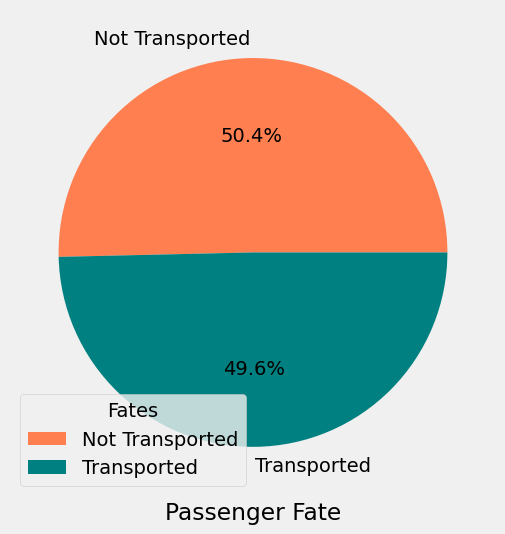

In [5]:
labels = ['Not Transported', 'Transported']

fig, ax = plt.subplots(figsize=(10, 6))
df['Transported'].value_counts().plot(kind='pie', ax=ax, labels=labels, autopct='%1.1f%%', colors=['coral', 'teal'])

ax.set_xlabel('Passenger Fate')
ax.set_ylabel('') 
ax.legend(title='Fates')

plt.show()

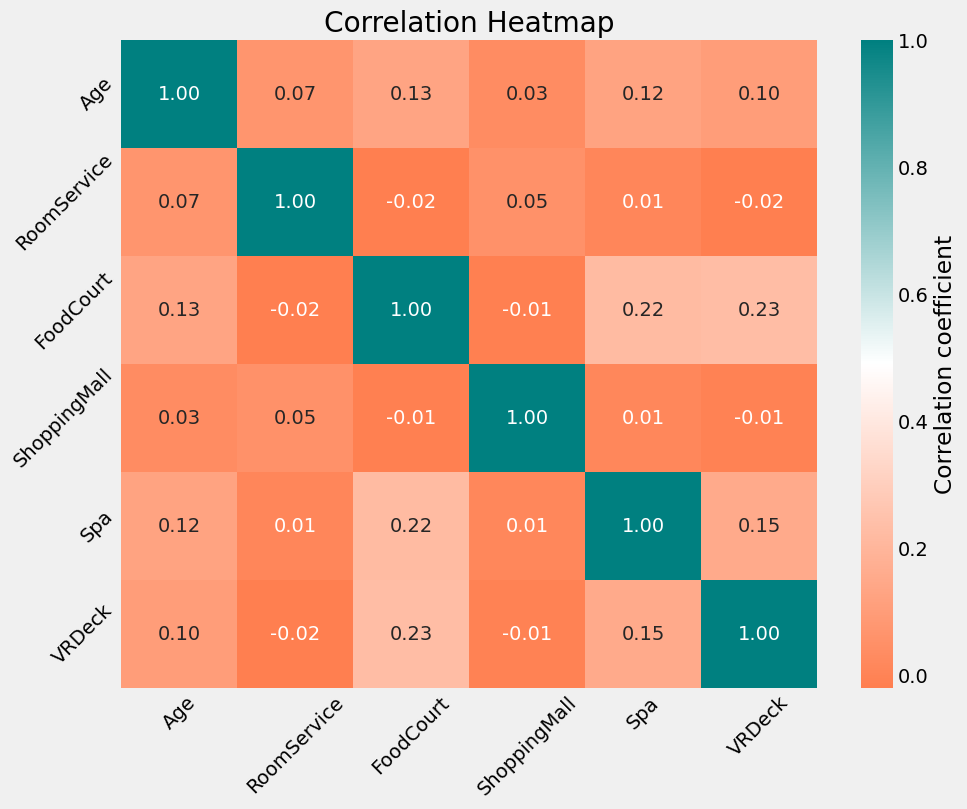

In [ ]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr = numeric_df.corr()

colors = ["coral", "white", "teal"] 
cmap = LinearSegmentedColormap.from_list("custom_coral_teal", colors)

plt.figure(figsize=(10, 8))  
sns.heatmap(corr, annot=True, fmt=".2f", cmap=cmap,
            xticklabels=corr.columns, yticklabels=corr.columns,
            cbar_kws={'label': 'Correlation coefficient'})

plt.title('Correlation Heatmap')
plt.xticks(rotation=45)  
plt.yticks(rotation=45)  
plt.show()


In [ ]:
df.isna().sum()

We can see we have quite a few missing values in almost every column so we should be thinking of imputation stratedgies.

In [ ]:
print(f'HomePlanet: {len(df.HomePlanet.unique())} \nCabin: {len(df.Cabin.unique())}\nDestination:{len(df.Destination.unique())}\nName:{len(df.Name.unique())}')

Too investigate the categorical columns we can immediately see `Name` and `Cabin` would greatly benefit from being split. It isn't necessary to reduce the dimensionality of the other columns and will encode them as is.

## Data Preprocessing
- In this stage we will be doing some feature engineering as discussed previously. We will be leaving some steps out here as we will cover them in our machine learning pipeline later. This allows us to tune some of the preprocessors like the imputer.

[🔝](#Table-of-Contents)





### Feature Engineering
The feature engineering steps will help you build the best model possible. The steps we will be doing are the following:
- Splitting Cabin into 3 columns composing of the parts
- Split Name into First Name and Last Name to correlate families
- Calculate a total column that comprises total spent on services

[🔝](#Table-of-Contents)

In [ ]:
df[['Cabin1', 'Cabin2', 'Cabin3']] = df['Cabin'].str.split('/', expand=True)
df[['FirstName', 'LastName']] = df['Name'].str.split(' ', expand=True)
df['total'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
df['AgeBin'] = pd.qcut(df['Age'].fillna(df['Age'].mode()[0]), q=5, labels=False)


df.drop(['Cabin', 'Name'], axis=1, inplace=True)

df.head()

In [10]:
print(f"Cabin1: {len(df.Cabin1.unique())} \nCabin2: {len(df.Cabin2.unique())}\nCabin3: {len(df.Cabin3.unique())}\nFirstName: {len(df.FirstName.unique())}\nLastName: {len(df.LastName.unique())}")

Cabin1: 9 
Cabin2: 1818
Cabin3: 3
FirstName: 2707
LastName: 2218


We can see we reduced the dimensionality pretty significantly for all of the columns. We can see cabin split very well with the high cardinality being a numerical features. We see First Name and Last Name are still high cardinality so we will need to take that into account when choosing an encoding stratedgy.

In [11]:
y = df['Transported'].astype(int)
df.drop(['Transported'], axis=1, inplace=True)

Here we are dropping the transported column before encoding so we can transform our submission dataframe to it later with dimension issues.

### Encoding
- Here we are going to encode our features with the BinaryEncoder. For low cardinality features it will be pretty similar to OneHotEncoding however it won't blow up our column size with high cardinality features. There are a lot of encoders out there so I would reccomend experimenting with some for potential improvements.

[🔝](#Table-of-Contents)

In [12]:
encoder = BinaryEncoder(cols=['FirstName', 'LastName', 'Cabin1', 'Cabin3', 'Destination', 'VIP', 'HomePlanet'], return_df=True)
df = encoder.fit_transform(df)

df.drop(['VIP_1'], axis=1,inplace=True)

df.columns

Index(['PassengerId', 'HomePlanet_0', 'HomePlanet_1', 'HomePlanet_2',
       'CryoSleep', 'Destination_0', 'Destination_1', 'Destination_2', 'Age',
       'VIP_0', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Cabin1_0', 'Cabin1_1', 'Cabin1_2', 'Cabin1_3', 'Cabin2', 'Cabin3_0',
       'Cabin3_1', 'FirstName_0', 'FirstName_1', 'FirstName_2', 'FirstName_3',
       'FirstName_4', 'FirstName_5', 'FirstName_6', 'FirstName_7',
       'FirstName_8', 'FirstName_9', 'FirstName_10', 'FirstName_11',
       'LastName_0', 'LastName_1', 'LastName_2', 'LastName_3', 'LastName_4',
       'LastName_5', 'LastName_6', 'LastName_7', 'LastName_8', 'LastName_9',
       'LastName_10', 'LastName_11', 'total', 'AgeBin'],
      dtype='object')

## Model Building
- In this section we will be building a machine learning pipeline where we perform imputing and scaling before passing into our model. This will be paired with a GridSearch to find the most optimal parameters. I have commented out the parametwers I've tried with other models for future use. 

[🔝](#Table-of-Contents)

In [13]:
# scaled_cols = ['Age', 'RoomService', 'FoodCourt']

X = df
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [15]:
xgb_params = {'n_estimators': 248, 'learning_rate': 0.08276477030425759, 'max_depth': 4, 'reg_lambda': 9.144307734410582, 'subsample': 0.9761017636523421}
rf_params = {'n_estimators': 829, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

xgb_model = XGBClassifier(**xgb_params)
rf_model = RandomForestClassifier(**rf_params)

pipeline = Pipeline([
    ('impute', KNNImputer(weights='distance', n_neighbors=3)),
    ('scale', MinMaxScaler()),
    ('xgb', VotingClassifier(
        estimators=[
            ('xgb', xgb_model),
            ('rf', rf_model)
        ]
    )),
])

best_model = pipeline.fit(X_train, Y_train)

Y_pred = best_model.predict(X_test)

# Y_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy}")

precision = precision_score(Y_test, Y_pred)
print(f"Precision: {precision}")

recall = recall_score(Y_test, Y_pred)
print(f"Recall: {recall}")

f1 = f1_score(Y_test, Y_pred)
print(f"F1 Score: {f1}")

# roc_auc = roc_auc_score(Y_test, Y_proba)
# print(f"ROC-AUC Score: {roc_auc}")

Accuracy: 0.8011494252873563
Precision: 0.8190954773869347
Recall: 0.7634660421545667
F1 Score: 0.7903030303030302


### Submission
- Here we are applying all of the preprocessing steps that we did with the training data. It's important that you perform these steps in the same order. It's also important that you using transform with the encoder and not fit. We also need to add a 0 column `LastName_11` since the encoding dimensionality of the test set is lower and needs to be fit to the pipeline.

[🔝](#Table-of-Contents)

In [16]:
df_test[['Cabin1', 'Cabin2', 'Cabin3']] = df_test['Cabin'].str.split('/', expand=True)
df_test[['FirstName', 'LastName']] = df_test['Name'].str.split(' ', expand=True)
df_test['total'] = df_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
df_test['AgeBin'] = pd.qcut(df_test['Age'].fillna(df_test['Age'].mode()[0]), q=5, labels=False)
df_test.drop(['Cabin', 'Name'], axis=1, inplace=True)
df_test = encoder.transform(df_test)
df_test.drop(['VIP_1'], axis=1,inplace=True)
df_test['LastName_11'] = 0


preds = best_model.predict(df_test)

In [17]:
preds = preds.astype(bool)
df_test['Transported'] = preds
submission_df = df_test[['PassengerId', 'Transported']]
submission_df.to_csv('submission.csv', index=False)